### HUGE NOTE NEED TO INSTALL PANDAS==2.2.3 FOR THIS, THEN NEED TO CHANGE IT BACK TO PANDAS==1.3.5 FOR TORCH GEOMETRIC I WANNA KMS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import networkx as nx
import pandas as pd
import geodatasets

import geopandas as gpd
from shapely.geometry import Point

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split, StaticGraphTemporalSignal

from haversine import haversine
import pickle

# GPU support
DEVICE = torch.device('cuda:3') # cuda
shuffle=True
batch_size = 32

In [2]:
beijing_aqi = pd.read_csv('../../../AirData/AQI/Stations/merged_full.csv')

In [3]:
beijing_aqi.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station',
       'locationLatitude', 'locationLongitude'],
      dtype='object')

In [4]:
from tqdm import tqdm, trange

class BeijingAirQualityDataset():
    def __init__(self, path, features=None, lat_long_vals=None, t_range=None, time_zone=None,  interval='hour', eq_weights=True):
        self.eq_weights = eq_weights
        self.interval = interval
        
        df = pd.read_csv(path)
        df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
        df['locationLatitude'] = df['locationLatitude'].round(6)
        df['locationLongitude'] = df['locationLongitude'].round(6)
        cols_to_keep = ['time', 'hour', 'locationLatitude', 'locationLongitude'] + list(features.keys())

        if features:
            df = df[cols_to_keep]
        if time_zone:
            df.time = df.time.dt.tz_convert(time_zone)
        if t_range:
            df = df[(df['time'] > t_range[0]) & (df['time'] < t_range[1])]
        if lat_long_vals is not None:
            df = df.merge(lat_long_vals, on=['locationLatitude', 'locationLongitude'])

        fin_df = df.groupby(['locationLatitude', 'locationLongitude', pd.Grouper(key='time', freq='h')]).agg(features).reset_index()
        fin_df['hour'] = df['hour']
        self.locations = fin_df[['locationLatitude', 'locationLongitude']].drop_duplicates()
        self.dataset = fin_df
        # self.length = min(fin_df.groupby(['locationLatitude', 'locationLongitude']).size())
    
    def _get_edge_weights(self):
        num_nodes = len(self.locations)
        self.mapper = {i: tuple(self.locations.iloc[i]) for i in range(num_nodes)}
        self.rev_map = {tuple(self.locations.iloc[i]): i for i in range(num_nodes)}

        edges = []
        weights = []

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                dist = haversine(tuple(self.locations.iloc[i]), tuple(self.locations.iloc[j]))
                if dist != 0:
                    if self.eq_weights:
                        edges.append([i, j])
                        edges.append([j, i]) 
                        weights.append(1)
                        weights.append(1)
                    else:
                        attr = 1 / (1 + haversine(tuple(self.locations.iloc[i]), tuple(self.locations.iloc[j])))
                        edges.append([i, j])
                        edges.append([j, i]) 
                        weights.append(attr)
                        weights.append(attr)

        self.edges = np.array(edges).T
        self.edge_weights = np.array(weights)

    def _get_task(self, start_pred):
        assert start_pred < 24 and start_pred > 1

        fin_df = self.dataset
        self.features = []
        self.targets = []

        date_list = list(pd.unique(fin_df['time'].dt.date))
        tbar = trange(len(date_list), desc='Creating Dataset')
        # features is per day
        for i in tbar:
            day = date_list[i]
            loc_list = []
            day_df = fin_df[fin_df['time'].dt.date == day]
            
            # numpy array per location per hour
            # array shape: len(locs) x features x 24
            for lat, long in self.locations.itertuples(index=False):
                features_list = []
                loc_df = day_df[(day_df['locationLatitude'] == lat) & (day_df['locationLongitude'] == long)]
                if not loc_df.empty:
                    for hr in range(24):
                        vals = loc_df[loc_df['hour'] == hr]
                        if not vals.empty:
                            features_list.append(np.array(vals.iloc[0, 3:-1]))
                        else:
                            features_list.append(np.zeros(len(fin_df.columns[3:-1])))
                    features_list_np = np.stack(features_list).T
                else:
                    features_list_np = np.zeros((len(fin_df.columns[3:-1]), 24))
                    
                loc_list.append(features_list_np)
            
            fin_arr = np.stack(loc_list).astype('float64')
            self.features.append(fin_arr[:, :, :start_pred])
            self.targets.append(fin_arr[:, :, start_pred:])
    
    def get_dataset(self, start_pred=12, set_dict=None):
        if set_dict:
            self.edges = set_dict['edges']
            self.edge_weights = set_dict['edge_weights']
            self.features = set_dict['features']
            self.targets = set_dict['targets']
        else:
            self._get_edge_weights()
            self._get_task(start_pred)
            
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset

In [5]:
feat = '1,2,3,4'
feat.split(',')

['1', '2', '3', '4']

In [6]:
beijing_aqi


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,locationLatitude,locationLongitude
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,39.982,116.397
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,39.982,116.397
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,39.982,116.397
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,39.982,116.397
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,39.982,116.397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong,39.878,116.352
420764,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong,39.878,116.352
420765,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong,39.878,116.352
420766,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong,39.878,116.352


In [7]:
features = {
    'PM2.5': 'mean',
    'PM10': 'mean',
    'WSPM': 'mean'
}

beijing_dataset = BeijingAirQualityDataset('../../../AirData/AQI/Stations/merged_full.csv',
                                        features=features, interval='hour', eq_weights=False)
# with open('beijingdata.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [8]:
beijing_dataset

In [9]:
len(pd.unique(beijing_dataset.dataset['time'].dt.date))

1461

In [10]:
beijing_dataset.get_dataset(12)

Creating Dataset:   2%|▏         | 35/1461 [00:07<05:03,  4.70it/s]


KeyboardInterrupt: 

In [ ]:
len(list(beijing_loader))

In [ ]:
import sys
sys.getsizeof(beijing_dataset.targets)

In [ ]:
beijing_dataset.features

AttributeError: 'BeijingAirQualityDataset' object has no attribute 'features'

In [ ]:
import pickle

a = {'features': beijing_dataset.features,
     'targets': beijing_dataset.targets,
     'edges': beijing_dataset.edges,
     'edge_weights': beijing_dataset.edge_weights}

with open('beijingdata.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
str = 'beijingdata.pickle'

In [ ]:
with open('beijingdata.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
aqi_dataset_quality = pd.read_hdf('../../../AirData/AQI/full437.h5', 'pm25')
aqi_dataset_stations = pd.read_hdf('../../../AirData/AQI/full437.h5', 'stations')

In [ ]:
aqi_dataset_stations

In [ ]:
aqi_dataset_quality

In [ ]:
plt.plot(aqi_dataset_quality[1001])

In [11]:
class AirQualityDataset():
    def __init__(self, path, features=None, lat_long_vals=None, t_range=None, time_zone=None,  interval='hour', eq_weights=True):
        self.eq_weights = eq_weights
        self.interval = interval
        
        df = pd.read_csv(path)
        df['time'] = pd.to_datetime(df['time'], utc=True)
        df['locationLatitude'] = df['locationLatitude'].round(6)
        df['locationLongitude'] = df['locationLongitude'].round(6)
        cols_to_keep = ['time', 'locationLatitude', 'locationLongitude'] + list(features.keys())

        if features:
            df = df[cols_to_keep]
        if time_zone:
            df.time = df.time.dt.tz_convert(time_zone)
        if t_range:
            df = df[(df['time'] > t_range[0]) & (df['time'] < t_range[1])]
        if not lat_long_vals.empty:
            df = df.merge(lat_long_vals, on=['locationLatitude', 'locationLongitude'])

        fin_df = df.groupby(['locationLatitude', 'locationLongitude', pd.Grouper(key='time', freq='h')]).agg(features).reset_index()
        fin_df['hour'] = fin_df['time'].dt.hour
        self.locations = fin_df[['locationLatitude', 'locationLongitude']].drop_duplicates()
        self.dataset = fin_df
        # self.length = min(fin_df.groupby(['locationLatitude', 'locationLongitude']).size())
    
    def _get_edge_weights(self):
        num_nodes = len(self.locations)
        self.mapper = {i: tuple(self.locations.iloc[i]) for i in range(num_nodes)}
        self.rev_map = {tuple(self.locations.iloc[i]): i for i in range(num_nodes)}

        edges = []
        weights = []

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                dist = haversine(tuple(self.locations.iloc[i]), tuple(self.locations.iloc[j]))
                if dist != 0:
                    if self.eq_weights:
                        edges.append([i, j])
                        edges.append([j, i]) 
                        weights.append(1)
                        weights.append(1)
                    else:
                        attr = 1 / (1 + haversine(tuple(self.locations.iloc[i]), tuple(self.locations.iloc[j])))
                        edges.append([i, j])
                        edges.append([j, i]) 
                        weights.append(attr)
                        weights.append(attr)

        self.edges = np.array(edges).T
        self.edge_weights = np.array(weights)

    def _get_task(self, start_pred):
        assert start_pred < 24 and start_pred > 1

        fin_df = self.dataset
        self.features = []
        self.targets = []

        # features is per day
        for day in list(pd.unique(fin_df['time'].dt.date)):
            loc_list = []
            day_df = fin_df[fin_df['time'].dt.date == day]
            
            # numpy array per location per hour
            # array shape: len(locs) x features x 24
            for lat, long in self.locations.itertuples(index=False):
                features_list = []
                loc_df = day_df[(day_df['locationLatitude'] == lat) & (day_df['locationLongitude'] == long)]
                if not loc_df.empty:
                    for hr in range(24):
                        vals = loc_df[loc_df['hour'] == hr]
                        if not vals.empty:
                            features_list.append(np.array(vals.iloc[0, 3:-1]))
                        else:
                            features_list.append(np.zeros(len(fin_df.columns[3:-1])))
                    features_list_np = np.stack(features_list).T
                else:
                    features_list_np = np.zeros((len(fin_df.columns[3:-1]), 24))
                    
                loc_list.append(features_list_np)
            
            fin_arr = np.stack(loc_list).astype('float64')
            self.features.append(fin_arr[:, :, :start_pred])
            self.targets.append(fin_arr[:, :, start_pred:])
    
    def get_dataset(self, start_pred=12):
        self._get_edge_weights()
        self._get_task(start_pred)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset

In [12]:
niwa_dataset = pd.read_csv('../../../AirData/Niwa/allNIWA_clarity.csv')
print(niwa_dataset.columns)
niwa_dataset

Index(['datasourceId', 'sourceId', 'time', 'locationLatitude',
       'locationLongitude', 'no2ConcIndividual.raw', 'no2ConcIndividual.value',
       'pm10ConcMassIndividual.value', 'pm10ConcNumIndividual.value',
       'pm1ConcMassIndividual.value', 'pm1ConcNumIndividual.value',
       'pm2_5ConcMassIndividual.value', 'pm2_5ConcNumIndividual.value',
       'relHumidAmbientIndividual.value', 'relHumidInternalIndividual.value',
       'temperatureAmbientIndividual.value',
       'temperatureInternalIndividual.value'],
      dtype='object')


,datasourceId,sourceId,time,locationLatitude,locationLongitude,no2ConcIndividual.raw,no2ConcIndividual.value,pm10ConcMassIndividual.value,pm10ConcNumIndividual.value,pm1ConcMassIndividual.value,pm1ConcNumIndividual.value,pm2_5ConcMassIndividual.value,pm2_5ConcNumIndividual.value,relHumidAmbientIndividual.value,relHumidInternalIndividual.value,temperatureAmbientIndividual.value,temperatureInternalIndividual.value
0,DATSA6745,A5VL6PWZ,2022-01-01T00:00:50Z,-36.844113,174.761371,1.31,NaN,NaN,2.02,NaN,1.90,NaN,1.98,NaN,53.99,NaN,23.62
1,DJEMB3886,A4L9FD9G,2022-01-01T00:03:52Z,-36.711932,174.740808,-32.29,NaN,NaN,2.60,NaN,2.45,NaN,2.55,NaN,47.21,NaN,31.92
2,DUHLQ3348,APKZGCR2,2022-01-01T00:03:59Z,-36.685404,174.433422,2.80,NaN,NaN,4.19,NaN,3.94,NaN,4.10,NaN,63.47,NaN,23.13
3,DBYYX8914,AJKS269C,2022-01-01T00:04:06Z,-36.906652,174.633079,0.81,NaN,NaN,2.90,NaN,2.71,NaN,2.85,NaN,48.31,NaN,26.97
4,DZWEQ1441,A2RG54VC,2022-01-01T00:06:46Z,-36.844113,174.761371,2.09,NaN,NaN,1.83,NaN,1.75,NaN,1.79,NaN,54.11,NaN,23.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2297014,DCPCY9241,AR7YPHC4,2024-12-02T21:53:29Z,-46.121073,169.963173,NaN,NaN,NaN,0.46,NaN,0.42,NaN,0.43,NaN,50.05,NaN,21.56
2297015,DEXQD3791,A97QL993,2024-12-02T21:59:45Z,-46.121348,169.961502,NaN,NaN,NaN,0.09,NaN,0.06,NaN,0.06,NaN,45.19,NaN,20.41
2297016,DCPCY9241,AR7YPHC4,2024-12-02T22:54:49Z,-46.121073,169.963173,NaN,NaN,NaN,0.29,NaN,0.25,NaN,0.25,NaN,48.18,NaN,22.77
2297017,DTFTC2789,A9T7MRWJ,2024-12-02T23:33:09Z,-46.126014,169.959830,NaN,NaN,NaN,0.10,NaN,0.07,NaN,0.07,NaN,46.01,NaN,20.74


In [13]:
features = {
    'pm10ConcNumIndividual.value': 'mean',     # Sum for value1
    'pm1ConcNumIndividual.value': 'mean',
    'pm2_5ConcNumIndividual.value': 'mean',
    'relHumidInternalIndividual.value': 'mean'
}
lat_long_vals = pd.DataFrame({
    'locationLatitude': [-36.844079, -36.844113, -36.711932, -36.898491, -36.906652, -36.876728],
    'locationLongitude': [174.762123, 174.761371, 174.740808, 174.591428, 174.633079, 174.703081]
})
t_range = ['2022-04-01', '2022-12-01']
time_zone = 'Pacific/Auckland'

In [14]:
df = niwa_dataset
df['time'] = pd.to_datetime(df['time'], utc=True)
df['locationLatitude'] = df['locationLatitude'].round(6)
df['locationLongitude'] = df['locationLongitude'].round(6)

In [15]:
cols_to_keep = ['time', 'locationLatitude', 'locationLongitude'] + list(features.keys())

if features:
    df = df[cols_to_keep]
if time_zone:
    df.time = df.time.dt.tz_convert(time_zone)
if t_range:
    df = df[(df['time'] > t_range[0]) & (df['time'] < t_range[1])]
df = df.merge(lat_long_vals, on=['locationLatitude', 'locationLongitude'], how='left')

/tmp/ipykernel_1060395/4269164268.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.time = df.time.dt.tz_convert(time_zone)


In [16]:
fin_df = df.groupby([pd.Grouper(key='time', freq='h'), 'locationLatitude', 'locationLongitude']).agg(features).reset_index()

In [17]:
fin_df['hour'] = fin_df['time'].dt.hour

In [18]:
locations = fin_df[['locationLatitude', 'locationLongitude']].drop_duplicates()

In [19]:
fin_df

,time,locationLatitude,locationLongitude,pm10ConcNumIndividual.value,pm1ConcNumIndividual.value,pm2_5ConcNumIndividual.value,relHumidInternalIndividual.value,hour
0,2022-04-01 00:00:00+13:00,-37.665700,176.187350,9.210000,8.860000,9.147500,79.610000,0
1,2022-04-01 00:00:00+13:00,-37.665620,176.186900,8.703333,8.340000,8.643333,80.163333,0
2,2022-04-01 00:00:00+13:00,-37.663730,176.207120,6.703333,6.393333,6.646667,80.430000,0
3,2022-04-01 00:00:00+13:00,-37.660640,176.209900,6.665000,6.432500,6.617500,78.930000,0
4,2022-04-01 00:00:00+13:00,-37.657000,176.207530,6.566667,6.283333,6.513333,81.553333,0
...,...,...,...,...,...,...,...,...
82455,2022-11-30 23:00:00+13:00,-43.912275,171.755170,4.522500,4.237500,4.445000,89.140000,23
82456,2022-11-30 23:00:00+13:00,-43.910856,171.761841,2.330000,2.180000,2.290000,56.930000,23
82457,2022-11-30 23:00:00+13:00,-36.906652,174.633079,2.330000,2.055000,2.235000,71.602500,23
82458,2022-11-30 23:00:00+13:00,-36.898491,174.591428,2.090000,1.873333,2.006667,68.893333,23


In [20]:
locations

,locationLatitude,locationLongitude
0,-37.665700,176.187350
1,-37.665620,176.186900
2,-37.663730,176.207120
3,-37.660640,176.209900
4,-37.657000,176.207530
5,-37.655330,176.198710
6,-37.650690,176.204010
7,-37.650270,176.187320
8,-37.645720,176.189070
9,-37.642530,176.183820


In [21]:
from haversine import haversine

num_nodes = len(locations)

mapper = {i: tuple(locations.iloc[i]) for i in range(num_nodes)}
rev_map = {tuple(locations.iloc[i]): i for i in range(num_nodes)}

edges = []
weights = []

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        dist = haversine(tuple(locations.iloc[i]), tuple(locations.iloc[j]))
        if dist != 0:
            attr = 1 / (1 + haversine(tuple(locations.iloc[i]), tuple(locations.iloc[j])))
            edges.append([i, j])
            edges.append([j, i]) 
            weights.append(attr)
            weights.append(attr)

edges = np.array(edges).T
weights = np.array(weights)

In [22]:
fin_df

,time,locationLatitude,locationLongitude,pm10ConcNumIndividual.value,pm1ConcNumIndividual.value,pm2_5ConcNumIndividual.value,relHumidInternalIndividual.value,hour
0,2022-04-01 00:00:00+13:00,-37.665700,176.187350,9.210000,8.860000,9.147500,79.610000,0
1,2022-04-01 00:00:00+13:00,-37.665620,176.186900,8.703333,8.340000,8.643333,80.163333,0
2,2022-04-01 00:00:00+13:00,-37.663730,176.207120,6.703333,6.393333,6.646667,80.430000,0
3,2022-04-01 00:00:00+13:00,-37.660640,176.209900,6.665000,6.432500,6.617500,78.930000,0
4,2022-04-01 00:00:00+13:00,-37.657000,176.207530,6.566667,6.283333,6.513333,81.553333,0
...,...,...,...,...,...,...,...,...
82455,2022-11-30 23:00:00+13:00,-43.912275,171.755170,4.522500,4.237500,4.445000,89.140000,23
82456,2022-11-30 23:00:00+13:00,-43.910856,171.761841,2.330000,2.180000,2.290000,56.930000,23
82457,2022-11-30 23:00:00+13:00,-36.906652,174.633079,2.330000,2.055000,2.235000,71.602500,23
82458,2022-11-30 23:00:00+13:00,-36.898491,174.591428,2.090000,1.873333,2.006667,68.893333,23


In [23]:
for lat, long in locations.itertuples(index=False):
    print(lat, long)

-37.6657 176.18735
-37.66562 176.1869
-37.66373 176.20712
-37.66064 176.2099
-37.657 176.20753
-37.65533 176.19871
-37.65069 176.20401
-37.65027 176.18732
-37.64572 176.18907
-37.64253 176.18382
-36.906652 174.633079
-36.844113 174.761371
-36.844079 174.762123
-36.711932 174.740808
-36.685404 174.433422
-36.898491 174.591428
-36.876728 174.703081
-43.912275 171.75517
-43.91573 171.756569
-43.909334 171.757669
-43.911666 171.761859
-43.909829 171.748109
-43.908502 171.767577
-43.905723 171.75417
-43.905444 171.764156
-43.902231 171.760153
-43.920242 171.782574
-43.915179 171.776271
-43.912975 171.772647
-43.927058 171.772016
-43.92292 171.766403
-43.910856 171.761841


In [24]:
fin_df

,time,locationLatitude,locationLongitude,pm10ConcNumIndividual.value,pm1ConcNumIndividual.value,pm2_5ConcNumIndividual.value,relHumidInternalIndividual.value,hour
0,2022-04-01 00:00:00+13:00,-37.665700,176.187350,9.210000,8.860000,9.147500,79.610000,0
1,2022-04-01 00:00:00+13:00,-37.665620,176.186900,8.703333,8.340000,8.643333,80.163333,0
2,2022-04-01 00:00:00+13:00,-37.663730,176.207120,6.703333,6.393333,6.646667,80.430000,0
3,2022-04-01 00:00:00+13:00,-37.660640,176.209900,6.665000,6.432500,6.617500,78.930000,0
4,2022-04-01 00:00:00+13:00,-37.657000,176.207530,6.566667,6.283333,6.513333,81.553333,0
...,...,...,...,...,...,...,...,...
82455,2022-11-30 23:00:00+13:00,-43.912275,171.755170,4.522500,4.237500,4.445000,89.140000,23
82456,2022-11-30 23:00:00+13:00,-43.910856,171.761841,2.330000,2.180000,2.290000,56.930000,23
82457,2022-11-30 23:00:00+13:00,-36.906652,174.633079,2.330000,2.055000,2.235000,71.602500,23
82458,2022-11-30 23:00:00+13:00,-36.898491,174.591428,2.090000,1.873333,2.006667,68.893333,23


In [25]:
len(list(pd.unique(fin_df['time'].dt.date)))

244

In [26]:
len(fin_df.columns[3:-1])

4

In [27]:
np.unique(fin_df['time'].dt.date, return_counts=True)

(array([datetime.date(2022, 4, 1), datetime.date(2022, 4, 2),
        datetime.date(2022, 4, 3), datetime.date(2022, 4, 4),
        datetime.date(2022, 4, 5), datetime.date(2022, 4, 6),
        datetime.date(2022, 4, 7), datetime.date(2022, 4, 8),
        datetime.date(2022, 4, 9), datetime.date(2022, 4, 10),
        datetime.date(2022, 4, 11), datetime.date(2022, 4, 12),
        datetime.date(2022, 4, 13), datetime.date(2022, 4, 14),
        datetime.date(2022, 4, 15), datetime.date(2022, 4, 16),
        datetime.date(2022, 4, 17), datetime.date(2022, 4, 18),
        datetime.date(2022, 4, 19), datetime.date(2022, 4, 20),
        datetime.date(2022, 4, 21), datetime.date(2022, 4, 22),
        datetime.date(2022, 4, 23), datetime.date(2022, 4, 24),
        datetime.date(2022, 4, 25), datetime.date(2022, 4, 26),
        datetime.date(2022, 4, 27), datetime.date(2022, 4, 28),
        datetime.date(2022, 4, 29), datetime.date(2022, 4, 30),
        datetime.date(2022, 5, 1), datetime.date(

In [28]:
temp_df = fin_df.iloc[:, [0, 1, 2, 3]]
temp_df['date'] = temp_df['time'].dt.date

/tmp/ipykernel_1060395/726789894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['date'] = temp_df['time'].dt.date


In [29]:
# Get the set of all unique (lat, long) pairs in the dataset
unique_lat_long_pairs = temp_df[['locationLatitude', 'locationLongitude']].drop_duplicates()

# Count unique lat-long entries per day
daily_counts = temp_df.groupby('date')[['locationLatitude', 'locationLongitude']].nunique()

# Filter out days that have all lat-long values
days_to_exclude = daily_counts[
    (daily_counts['locationLatitude'] == unique_lat_long_pairs['locationLongitude'].nunique()) & 
    (daily_counts['locationLatitude'] == unique_lat_long_pairs['locationLongitude'].nunique())
].index

# Keep only the days that do NOT contain all lat-long values
filtered_df = temp_df[temp_df['date'].isin(days_to_exclude)]

print(np.unique(filtered_df['date']))


[]


In [30]:
unique_lat_long_pairs

,locationLatitude,locationLongitude
0,-37.665700,176.187350
1,-37.665620,176.186900
2,-37.663730,176.207120
3,-37.660640,176.209900
4,-37.657000,176.207530
5,-37.655330,176.198710
6,-37.650690,176.204010
7,-37.650270,176.187320
8,-37.645720,176.189070
9,-37.642530,176.183820


In [31]:
# CODE FOR RESTRICTIVE FEATURE MATRIX

features = []
targets = []

# features is per day
for day in list(pd.unique(fin_df['time'].dt.date)):
    loc_list = []
    day_df = fin_df[fin_df['time'].dt.date == day]
    
    # numpy array per location per hour
    # array shape: len(locs) x features x 24
    for lat, long in locations.itertuples(index=False):
        features_list = []
        loc_df = day_df[(day_df['locationLatitude'] == lat) & (day_df['locationLongitude'] == long)]
        if not loc_df.empty:
            for hr in range(24):
                vals = loc_df[loc_df['hour'] == hr]
                if not vals.empty:
                    features_list.append(np.array(vals.iloc[0, 3:-1]))
                else:
                    features_list.append(np.zeros(len(fin_df.columns[3:-1])))
            features_list_np = np.stack(features_list).T
        else:
            loc_list = []
            break

        loc_list.append(features_list_np)
    if loc_list:
        print(day)
        features.append(np.stack(loc_list))

In [32]:
start_pred = 12
features = []
targets = []

# features is per day
for day in list(pd.unique(fin_df['time'].dt.date)):
    loc_list = []
    day_df = fin_df[fin_df['time'].dt.date == day]
    
    # numpy array per location per hour
    # array shape: len(locs) x features x 24
    for lat, long in locations.itertuples(index=False):
        features_list = []
        loc_df = day_df[(day_df['locationLatitude'] == lat) & (day_df['locationLongitude'] == long)]
        if not loc_df.empty:
            for hr in range(24):
                vals = loc_df[loc_df['hour'] == hr]
                if not vals.empty:
                    features_list.append(np.array(vals.iloc[0, 3:-1]))
                else:
                    features_list.append(np.zeros(len(fin_df.columns[3:-1])))
            features_list_np = np.stack(features_list).T
        else:
            features_list_np = np.zeros((len(fin_df.columns[3:-1]), 24))
            
        loc_list.append(features_list_np)
    
    fin_arr = np.stack(loc_list)
    features.append(fin_arr[:, :, :start_pred])
    targets.append(fin_arr[:, :, start_pred:])

In [33]:
targets[0].shape

(32, 4, 12)

______________________________________

In [34]:
t_range = ['2022-01-01', '2022-12-01']
group_by = 'pm2_5ConcNumIndividual.value'


niwa_dataset['time'] = pd.to_datetime(niwa_dataset['time'], utc=True)
niwa_dataset.time = niwa_dataset.time.dt.tz_convert('Pacific/Auckland')
# niwa_dataset = niwa_dataset[(niwa_dataset['time'] > t_range[0]) & (niwa_dataset['time'] < t_range[1])]

lat_long = list(niwa_dataset[['locationLongitude', 'locationLatitude']].drop_duplicates()\
                .itertuples(index=False, name=None))

In [35]:
len(lat_long)

332

In [36]:
niwa_dataset['locationLatitude'] = niwa_dataset['locationLatitude'].round(6)
niwa_dataset['locationLongitude'] = niwa_dataset['locationLongitude'].round(6)

In [37]:
niwa_dataset

,datasourceId,sourceId,time,locationLatitude,locationLongitude,no2ConcIndividual.raw,no2ConcIndividual.value,pm10ConcMassIndividual.value,pm10ConcNumIndividual.value,pm1ConcMassIndividual.value,pm1ConcNumIndividual.value,pm2_5ConcMassIndividual.value,pm2_5ConcNumIndividual.value,relHumidAmbientIndividual.value,relHumidInternalIndividual.value,temperatureAmbientIndividual.value,temperatureInternalIndividual.value
0,DATSA6745,A5VL6PWZ,2022-01-01 13:00:50+13:00,-36.844113,174.761371,1.31,NaN,NaN,2.02,NaN,1.90,NaN,1.98,NaN,53.99,NaN,23.62
1,DJEMB3886,A4L9FD9G,2022-01-01 13:03:52+13:00,-36.711932,174.740808,-32.29,NaN,NaN,2.60,NaN,2.45,NaN,2.55,NaN,47.21,NaN,31.92
2,DUHLQ3348,APKZGCR2,2022-01-01 13:03:59+13:00,-36.685404,174.433422,2.80,NaN,NaN,4.19,NaN,3.94,NaN,4.10,NaN,63.47,NaN,23.13
3,DBYYX8914,AJKS269C,2022-01-01 13:04:06+13:00,-36.906652,174.633079,0.81,NaN,NaN,2.90,NaN,2.71,NaN,2.85,NaN,48.31,NaN,26.97
4,DZWEQ1441,A2RG54VC,2022-01-01 13:06:46+13:00,-36.844113,174.761371,2.09,NaN,NaN,1.83,NaN,1.75,NaN,1.79,NaN,54.11,NaN,23.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2297014,DCPCY9241,AR7YPHC4,2024-12-03 10:53:29+13:00,-46.121073,169.963173,NaN,NaN,NaN,0.46,NaN,0.42,NaN,0.43,NaN,50.05,NaN,21.56
2297015,DEXQD3791,A97QL993,2024-12-03 10:59:45+13:00,-46.121348,169.961502,NaN,NaN,NaN,0.09,NaN,0.06,NaN,0.06,NaN,45.19,NaN,20.41
2297016,DCPCY9241,AR7YPHC4,2024-12-03 11:54:49+13:00,-46.121073,169.963173,NaN,NaN,NaN,0.29,NaN,0.25,NaN,0.25,NaN,48.18,NaN,22.77
2297017,DTFTC2789,A9T7MRWJ,2024-12-03 12:33:09+13:00,-46.126014,169.959830,NaN,NaN,NaN,0.10,NaN,0.07,NaN,0.07,NaN,46.01,NaN,20.74


In [38]:
filter_coords = pd.DataFrame({
    'locationLatitude': [-36.844079, -36.844113, -36.711932, -36.898491, -36.906652, -36.876728],
    'locationLongitude': [174.762123, 174.761371, 174.740808, 174.591428, 174.633079, 174.703081]
})

pd.unique(niwa_dataset.merge(filter_coords, on=['locationLatitude', 'locationLongitude'])['locationLatitude'])

array([-36.844113, -36.711932, -36.906652, -36.876728, -36.844079,
       -36.898491])

In [39]:
lat_long

[(174.761371, -36.844113),
 (174.740808, -36.711932),
 (174.433422, -36.685404),
 (174.633079, -36.906652),
 (174.703081, -36.876728),
 (174.762123, -36.844079),
 (174.761468, -36.844471),
 (174.768648, -36.864362),
 (176.1869, -37.66562),
 (176.18735, -37.6657),
 (176.18382, -37.64253),
 (176.18732, -37.65027),
 (176.20712, -37.66373),
 (176.18907, -37.64572),
 (176.2099, -37.66064),
 (176.20401, -37.65069),
 (176.19871, -37.65533),
 (176.20753, -37.657),
 (174.591428, -36.898491),
 (171.75517, -43.912275),
 (171.756569, -43.91573),
 (171.757669, -43.909334),
 (171.760153, -43.902231),
 (171.761859, -43.911666),
 (171.767577, -43.908502),
 (171.75417, -43.905723),
 (171.748109, -43.909829),
 (171.764156, -43.905444),
 (171.772647, -43.912975),
 (171.782574, -43.920242),
 (171.776271, -43.915179),
 (171.772016, -43.927058),
 (171.766403, -43.92292),
 (171.761841, -43.910856),
 (169.384437, -45.249685),
 (169.390627, -45.254579),
 (169.389185, -45.256699),
 (169.378959, -45.244408),
 (1

In [40]:
geodatasets.data

{'geoda': {'airbnb': {'url': 'https://geodacenter.github.io/data-and-lab//data/airbnb.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.airbnb',
   'description': 'Airbnb rentals, socioeconomics, and crime in Chicago',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 21,
   'details': 'https://geodacenter.github.io/data-and-lab//airbnb/',
   'hash': 'a2ab1e3f938226d287dd76cde18c00e2d3a260640dd826da7131827d9e76c824',
   'filename': 'airbnb.zip'},
  'atlanta': {'url': 'https://geodacenter.github.io/data-and-lab//data/atlanta_hom.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.atlanta',
   'description': 'Atlanta, GA region homicide counts and rates',
   'geometry_type': 'Polygon',
   'nrows': 90,
   'ncols': 24,
   'details': 'https://geodacenter.github.io/data-and-lab//atlanta_old/',
   'hash': 'a33a76e12168fe84361e60c88a9df4856730487305846c559715c89b1a2b5e09',
   'filename': 'atlanta_hom.zip',
   'members': ['atlanta_hom/atl_hom.geojson']},
  'cars': {'url': 'https://geodacenter.github.io/data-and-lab//data/Abandoned_Vehicles_Map.csv',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.cars',
   'description': '2011 abandoned vehicles in Chicago (311 complaints).',
   'geometry_type': 'Point',
   'nrows': 137867,
   'ncols': 21,
   'details': 'https://geodacenter.github.io/data-and-lab//1-source-and-description/',
   'hash': '6a0b23bc7eda2dcf1af02d43ccf506b24ca8d8c6dc2fe86a2a1cc051b03aae9e',
   'filename': 'Abandoned_Vehicles_Map.csv'},
  'charleston1': {'url': 'https://geodacenter.github.io/data-and-lab//data/CharlestonMSA.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.charleston1',
   'description': '2000 Census Tract Data for Charleston, SC MSA and counties',
   'geometry_type': 'Polygon',
   'nrows': 117,
   'ncols': 31,
   'details': 'https://geodacenter.github.io/data-and-lab//charleston-1_old/',
   'hash': '4a4fa9c8dd4231ae0b2f12f24895b8336bcab0c28c48653a967cffe011f63a7c',
   'filename': 'CharlestonMSA.zip',
   'members': ['CharlestonMSA/sc_final_census2.gpkg']},
  'charleston2': {'url': 'https://geodacenter.github.io/data-and-lab//data/CharlestonMSA2.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.charleston2',
   'description': '1998 and 2001 Zip Code Business Patterns (Census Bureau) for Charleston, SC MSA',
   'geometry_type': 'Polygon',
   'nrows': 42,
   'ncols': 60,
   'details': 'https://geodacenter.github.io/data-and-lab//charleston2/',
   'hash': '056d5d6e236b5bd95f5aee26c77bbe7d61bd07db5aaf72866c2f545205c1d8d7',
   'filename': 'CharlestonMSA2.zip',
   'members': ['CharlestonMSA2/CharlestonMSA2.gpkg']},
  'chicago_health': {'url': 'https://geodacenter.github.io/data-and-lab//data/comarea.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.chicago_health',
   'description': 'Chicago Health + Socio-Economics',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 87,
   'details': 'https://geodacenter.github.io/data-and-lab//comarea_vars/',
   'hash': '4e872adb552786eae2fcd745524696e5e4cd33cc9a6c032471c0e75328871401',
   'filename': 'comarea.zip'},
  'chicago_commpop': {'url': 'https://geodacenter.github.io/data-and-lab//data/chicago_commpop.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.chicago_commpop',
   'description': 'Chicago Community Area Population Percent Change for 2000 and 2010',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 9,
   'details': 'https://geodacenter.github.io/data-and-lab//commpop/',
   'hash': '1dbebb50c8ea47e2279ea819ef64ba793bdee2b88e4716bd6c6ec0e0d8e0e05b',
   'filename': 'c

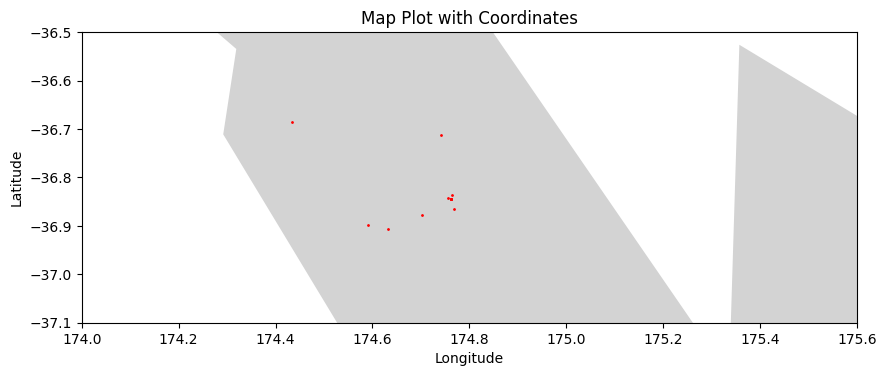

In [41]:
# Create a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in lat_long]
gdf = gpd.GeoDataFrame(geometry=geometry)

# Load detailed map
gdf_world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# Plot the map
fig, ax = plt.subplots(figsize=(10, 5))
gdf_world.plot(ax=ax, color='lightgray')  # Plot world map
gdf.plot(ax=ax, color='red', markersize=1)  # Plot points with smaller size

# Zoom into Auckland
ax.set_xlim([166, 179])
ax.set_ylim([-48, -34])

ax.set_xlim([174, 175.6])
ax.set_ylim([-37.1, -36.5])

# CHC
# ax.set_xlim([171.7, 171.85])
# ax.set_ylim([-43.8, -44])

# DUNE
# ax.set_xlim([168.25, 168.50])
# ax.set_ylim([-46.50, -46.25])

# Show the plot
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map Plot with Coordinates")
plt.show()

In [42]:
auckland_dataset = niwa_dataset[(niwa_dataset['locationLatitude'] < -36.7) & (-37.0 < niwa_dataset['locationLatitude'])]

In [43]:
auck_lat_long = list(auckland_dataset[['locationLatitude', 'locationLongitude']].drop_duplicates()\
                .itertuples(index=False, name=None))

In [44]:
grouped = auckland_dataset.groupby(['locationLatitude', 'locationLongitude']).size().reset_index(name='count')
grouped.sort_values(by=['count'])

,locationLatitude,locationLongitude,count
10,-36.836122,174.764116,892
9,-36.843318,174.757056,907
3,-36.864362,174.768648,1380
5,-36.844471,174.761468,2838
4,-36.844476,174.761475,4324
8,-36.843620,174.761667,7204
7,-36.844079,174.762123,11243
6,-36.844113,174.761371,16345
11,-36.711932,174.740808,17119
1,-36.898491,174.591428,21240


In [45]:
min(auckland_dataset.groupby(['locationLatitude', 'locationLongitude']).size())

892

In [46]:
grouped2 = auckland_dataset.groupby(['locationLatitude', 'locationLongitude']).agg(
    start_date=('time', 'min'),
    end_date=('time', 'max')
).reset_index()

grouped2

,locationLatitude,locationLongitude,start_date,end_date
0,-36.906652,174.633079,2022-01-01 13:04:06+13:00,2024-05-27 11:35:34+12:00
1,-36.898491,174.591428,2022-04-20 16:19:03+12:00,2024-02-27 10:08:51+13:00
2,-36.876728,174.703081,2022-01-01 13:07:54+13:00,2024-05-09 07:39:07+12:00
3,-36.864362,174.768648,2022-01-26 09:37:36+13:00,2022-02-18 16:28:26+13:00
4,-36.844476,174.761475,2023-05-30 11:22:53+12:00,2023-07-05 15:30:00+12:00
5,-36.844471,174.761468,2022-01-25 11:48:47+13:00,2022-02-18 16:24:37+13:00
6,-36.844113,174.761371,2022-01-01 13:00:50+13:00,2022-06-08 10:12:37+12:00
7,-36.844079,174.762123,2022-01-01 13:12:45+13:00,2022-06-08 09:54:48+12:00
8,-36.843620,174.761667,2024-02-01 15:42:56+13:00,2024-04-28 11:44:52+12:00
9,-36.843318,174.757056,2023-09-01 14:53:12+12:00,2024-05-30 08:13:19+12:00


In [47]:
auckland_dataset[auckland_dataset['locationLatitude'] == -36.711932]

,datasourceId,sourceId,time,locationLatitude,locationLongitude,no2ConcIndividual.raw,no2ConcIndividual.value,pm10ConcMassIndividual.value,pm10ConcNumIndividual.value,pm1ConcMassIndividual.value,pm1ConcNumIndividual.value,pm2_5ConcMassIndividual.value,pm2_5ConcNumIndividual.value,relHumidAmbientIndividual.value,relHumidInternalIndividual.value,temperatureAmbientIndividual.value,temperatureInternalIndividual.value
1,DJEMB3886,A4L9FD9G,2022-01-01 13:03:52+13:00,-36.711932,174.740808,-32.29,NaN,NaN,2.60,NaN,2.45,NaN,2.55,NaN,47.21,NaN,31.92
6,DNRLG9756,AMFVFV85,2022-01-01 13:07:20+13:00,-36.711932,174.740808,3.76,NaN,NaN,4.31,NaN,4.08,NaN,4.24,NaN,65.74,NaN,21.33
10,DJEMB3886,A4L9FD9G,2022-01-01 13:21:06+13:00,-36.711932,174.740808,-48.58,NaN,NaN,2.61,NaN,2.46,NaN,2.56,NaN,40.39,NaN,34.66
15,DNRLG9756,AMFVFV85,2022-01-01 13:24:42+13:00,-36.711932,174.740808,2.62,NaN,NaN,3.94,NaN,3.71,NaN,3.87,NaN,65.20,NaN,21.60
20,DJEMB3886,A4L9FD9G,2022-01-01 13:38:22+13:00,-36.711932,174.740808,-57.16,NaN,NaN,2.45,NaN,2.28,NaN,2.39,NaN,38.93,NaN,36.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148910,DNRLG9756,AMFVFV85,2022-05-29 15:24:39+12:00,-36.711932,174.740808,2.56,NaN,NaN,1.01,NaN,0.92,NaN,0.97,NaN,51.65,NaN,21.38
148952,DNRLG9756,AMFVFV85,2022-05-29 19:20:54+12:00,-36.711932,174.740808,21.23,NaN,NaN,1.82,NaN,1.69,NaN,1.78,NaN,66.85,NaN,17.78
149037,DNRLG9756,AMFVFV85,2022-05-30 03:24:34+12:00,-36.711932,174.740808,14.27,NaN,NaN,1.38,NaN,1.25,NaN,1.31,NaN,64.39,NaN,21.18
149080,DNRLG9756,AMFVFV85,2022-05-30 07:22:15+12:00,-36.711932,174.740808,12.86,NaN,NaN,1.43,NaN,1.29,NaN,1.37,NaN,64.38,NaN,21.56


In [48]:
import seaborn as sns

auckland_dataset['location'] = auckland_dataset.apply(lambda row: f"({row['locationLatitude']}, {row['locationLongitude']})", axis=1)

/tmp/ipykernel_1060395/1927336704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auckland_dataset['location'] = auckland_dataset.apply(lambda row: f"({row['locationLatitude']}, {row['locationLongitude']})", axis=1)


In [49]:
locations

,locationLatitude,locationLongitude
0,-37.665700,176.187350
1,-37.665620,176.186900
2,-37.663730,176.207120
3,-37.660640,176.209900
4,-37.657000,176.207530
5,-37.655330,176.198710
6,-37.650690,176.204010
7,-37.650270,176.187320
8,-37.645720,176.189070
9,-37.642530,176.183820


In [50]:
for i in locations.itertuples(index=False):
    print(i)

Pandas(locationLatitude=-37.6657, locationLongitude=176.18735)
Pandas(locationLatitude=-37.66562, locationLongitude=176.1869)
Pandas(locationLatitude=-37.66373, locationLongitude=176.20712)
Pandas(locationLatitude=-37.66064, locationLongitude=176.2099)
Pandas(locationLatitude=-37.657, locationLongitude=176.20753)
Pandas(locationLatitude=-37.65533, locationLongitude=176.19871)
Pandas(locationLatitude=-37.65069, locationLongitude=176.20401)
Pandas(locationLatitude=-37.65027, locationLongitude=176.18732)
Pandas(locationLatitude=-37.64572, locationLongitude=176.18907)
Pandas(locationLatitude=-37.64253, locationLongitude=176.18382)
Pandas(locationLatitude=-36.906652, locationLongitude=174.633079)
Pandas(locationLatitude=-36.844113, locationLongitude=174.761371)
Pandas(locationLatitude=-36.844079, locationLongitude=174.762123)
Pandas(locationLatitude=-36.711932, locationLongitude=174.740808)
Pandas(locationLatitude=-36.685404, locationLongitude=174.433422)
Pandas(locationLatitude=-36.898491,

        locationLatitude  locationLongitude
0             -36.844113         174.761371
1             -36.711932         174.740808
3             -36.906652         174.633079
7             -36.876728         174.703081
8             -36.844079         174.762123
128684        -36.898491         174.591428


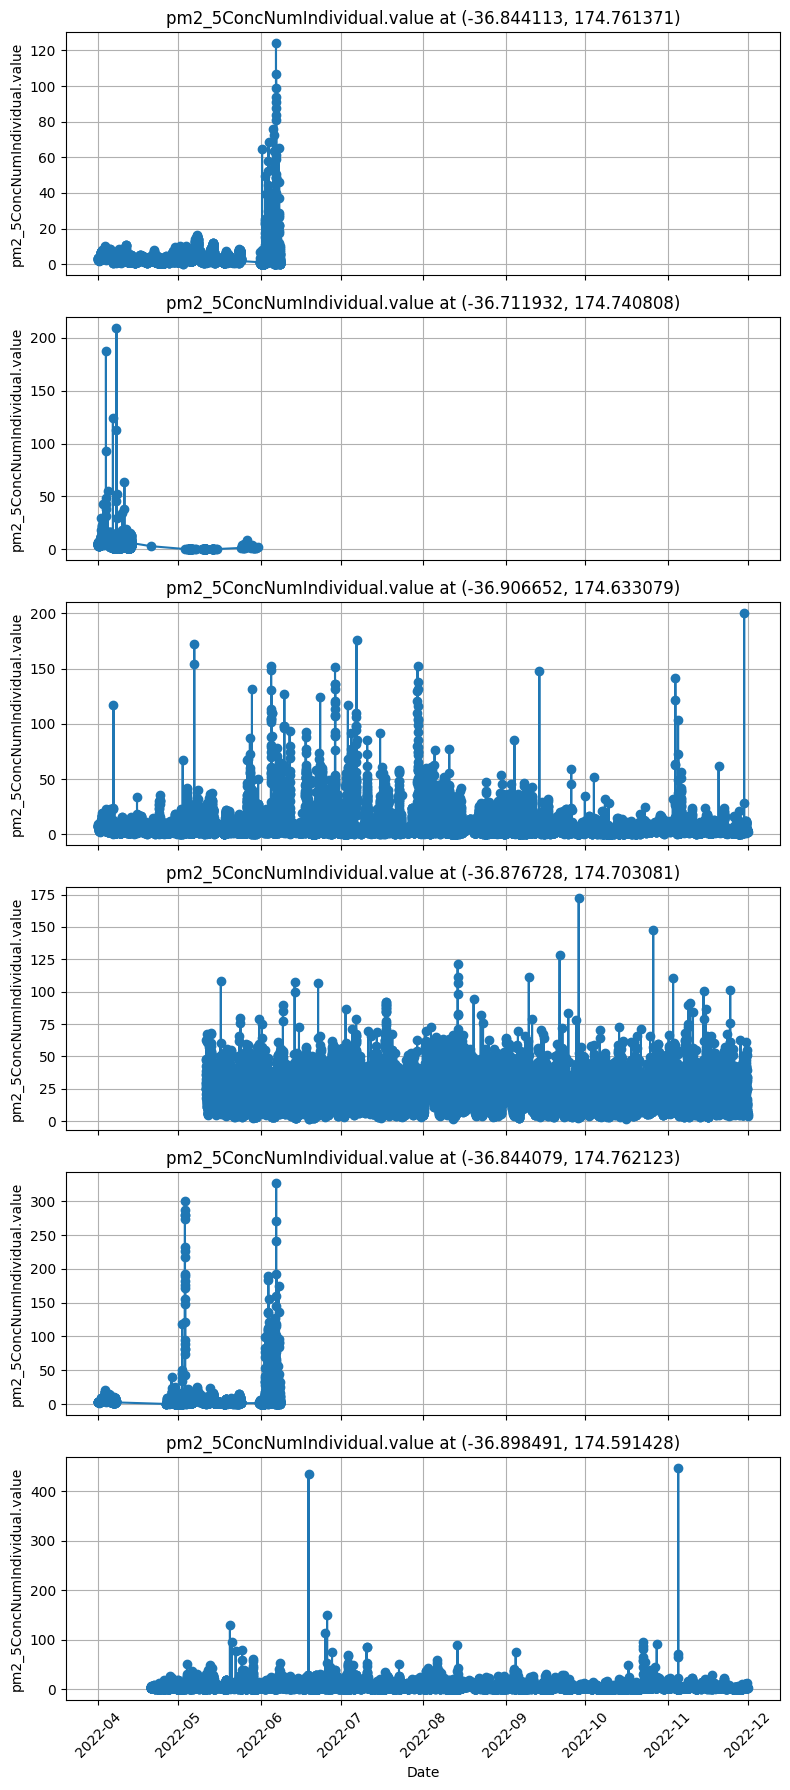

In [61]:
locations = auckland_dataset[['locationLatitude', 'locationLongitude']].drop_duplicates()
# pm2_5ConcNumIndividual.value, temperatureInternalIndividual.value
print(locations.iloc[[0, 1, 2, 3, 4, 7]])
locations = locations.iloc[[0, 1, 2, 3, 4, 7]]
ranges = ['2022-04-01', '2022-12-01']

# Create subplots
fig, axes = plt.subplots(len(locations), 1, figsize=(8, len(locations) * 3), sharex=True)

if len(locations) == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

# Plot each lat-long pair in a separate subplot
for ax, (lat, lon) in zip(axes, locations.itertuples(index=False)):
    subset = auckland_dataset[(auckland_dataset['locationLatitude'] == lat) & (auckland_dataset['locationLongitude'] == lon) &
                              (auckland_dataset['time'] > ranges[0]) & (auckland_dataset['time'] < ranges[1])]
    
    ax.plot(subset['time'], subset[group_by], marker='o', linestyle='-')

    # Labels and formatting
    ax.set_title(f'{group_by} at ({lat}, {lon})')
    ax.set_ylabel(f'{group_by}')
    ax.grid(True)

# Formatting for x-axis
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [52]:
auckland_dataset.dtypes

datasourceId                                                     object
sourceId                                                         object
time                                   datetime64[ns, Pacific/Auckland]
locationLatitude                                                float64
locationLongitude                                               float64
no2ConcIndividual.raw                                           float64
no2ConcIndividual.value                                         float64
pm10ConcMassIndividual.value                                    float64
pm10ConcNumIndividual.value                                     float64
pm1ConcMassIndividual.value                                     float64
pm1ConcNumIndividual.value                                      float64
pm2_5ConcMassIndividual.value                                   float64
pm2_5ConcNumIndividual.value                                    float64
relHumidAmbientIndividual.value                                 

In [53]:
auckland_dataset

,datasourceId,sourceId,time,locationLatitude,locationLongitude,no2ConcIndividual.raw,no2ConcIndividual.value,pm10ConcMassIndividual.value,pm10ConcNumIndividual.value,pm1ConcMassIndividual.value,pm1ConcNumIndividual.value,pm2_5ConcMassIndividual.value,pm2_5ConcNumIndividual.value,relHumidAmbientIndividual.value,relHumidInternalIndividual.value,temperatureAmbientIndividual.value,temperatureInternalIndividual.value,location
0,DATSA6745,A5VL6PWZ,2022-01-01 13:00:50+13:00,-36.844113,174.761371,1.31,NaN,NaN,2.02,NaN,1.90,NaN,1.98,NaN,53.99,NaN,23.62,"(-36.844113, 174.761371)"
1,DJEMB3886,A4L9FD9G,2022-01-01 13:03:52+13:00,-36.711932,174.740808,-32.29,NaN,NaN,2.60,NaN,2.45,NaN,2.55,NaN,47.21,NaN,31.92,"(-36.711932, 174.740808)"
3,DBYYX8914,AJKS269C,2022-01-01 13:04:06+13:00,-36.906652,174.633079,0.81,NaN,NaN,2.90,NaN,2.71,NaN,2.85,NaN,48.31,NaN,26.97,"(-36.906652, 174.633079)"
4,DZWEQ1441,A2RG54VC,2022-01-01 13:06:46+13:00,-36.844113,174.761371,2.09,NaN,NaN,1.83,NaN,1.75,NaN,1.79,NaN,54.11,NaN,23.63,"(-36.844113, 174.761371)"
6,DNRLG9756,AMFVFV85,2022-01-01 13:07:20+13:00,-36.711932,174.740808,3.76,NaN,NaN,4.31,NaN,4.08,NaN,4.24,NaN,65.74,NaN,21.33,"(-36.711932, 174.740808)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658185,DUHLQ3348,APKZGCR2,2024-05-30 04:08:43+12:00,-36.843318,174.757056,-4.26,NaN,NaN,1.98,NaN,1.73,NaN,1.93,NaN,NaN,NaN,NaN,"(-36.843318, 174.757056)"
1658372,DUHLQ3348,APKZGCR2,2024-05-30 05:09:51+12:00,-36.843318,174.757056,-3.24,NaN,NaN,2.03,NaN,1.85,NaN,1.96,NaN,NaN,NaN,NaN,"(-36.843318, 174.757056)"
1658561,DUHLQ3348,APKZGCR2,2024-05-30 06:10:59+12:00,-36.843318,174.757056,3.21,NaN,NaN,16.22,NaN,15.35,NaN,16.05,NaN,NaN,NaN,NaN,"(-36.843318, 174.757056)"
1658750,DUHLQ3348,APKZGCR2,2024-05-30 07:12:11+12:00,-36.843318,174.757056,4.17,NaN,NaN,28.13,NaN,26.44,NaN,27.76,NaN,NaN,NaN,NaN,"(-36.843318, 174.757056)"


In [54]:
auckland_dataset['day_of_year'] = auckland_dataset['time'].dt.hour


/tmp/ipykernel_1060395/3218730381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auckland_dataset['day_of_year'] = auckland_dataset['time'].dt.hour


In [55]:
niwa_dataset.head()

,datasourceId,sourceId,time,locationLatitude,locationLongitude,no2ConcIndividual.raw,no2ConcIndividual.value,pm10ConcMassIndividual.value,pm10ConcNumIndividual.value,pm1ConcMassIndividual.value,pm1ConcNumIndividual.value,pm2_5ConcMassIndividual.value,pm2_5ConcNumIndividual.value,relHumidAmbientIndividual.value,relHumidInternalIndividual.value,temperatureAmbientIndividual.value,temperatureInternalIndividual.value
0,DATSA6745,A5VL6PWZ,2022-01-01 13:00:50+13:00,-36.844113,174.761371,1.31,NaN,NaN,2.02,NaN,1.90,NaN,1.98,NaN,53.99,NaN,23.62
1,DJEMB3886,A4L9FD9G,2022-01-01 13:03:52+13:00,-36.711932,174.740808,-32.29,NaN,NaN,2.60,NaN,2.45,NaN,2.55,NaN,47.21,NaN,31.92
2,DUHLQ3348,APKZGCR2,2022-01-01 13:03:59+13:00,-36.685404,174.433422,2.80,NaN,NaN,4.19,NaN,3.94,NaN,4.10,NaN,63.47,NaN,23.13
3,DBYYX8914,AJKS269C,2022-01-01 13:04:06+13:00,-36.906652,174.633079,0.81,NaN,NaN,2.90,NaN,2.71,NaN,2.85,NaN,48.31,NaN,26.97
4,DZWEQ1441,A2RG54VC,2022-01-01 13:06:46+13:00,-36.844113,174.761371,2.09,NaN,NaN,1.83,NaN,1.75,NaN,1.79,NaN,54.11,NaN,23.63


In [56]:
agg_funcs = {
    'pm10ConcNumIndividual.value': 'mean',     # Sum for value1
    'pm1ConcNumIndividual.value': 'mean',
    'pm2_5ConcNumIndividual.value': 'mean',
    'relHumidInternalIndividual.value': 'mean'
}

test = auckland_dataset.groupby([pd.Grouper(key='time', freq='h'), 'locationLatitude', 'locationLongitude']).agg({'pm2_5ConcNumIndividual.value': 'mean'}).reset_index()

In [57]:
for i in range(min(test['day_of_year']), max(test['day_of_year'])+1):
    pass

print(i)

KeyError: 'day_of_year'

In [ ]:
min_len = min(test.groupby(['locationLatitude', 'locationLongitude']).size())
min_len

In [ ]:
test['day_of_year'] = test['time'].dt.day_of_year

In [ ]:
np.unique(test['day_of_year'], return_counts = True)

In [ ]:
# Group by lat-long and day of the year, then take the average temperature
df_avg = auckland_dataset.groupby(['locationLatitude', 'locationLongitude', 'day_of_year']).agg({group_by: 'mean'}).reset_index()

# Get unique latitude-longitude pairs
# locations = df_avg[['locationLatitude', 'locationLongitude']].drop_duplicates()
# print(locations)

# Create subplots
fig, axes = plt.subplots(len(locations), 1, figsize=(8, len(locations) * 3), sharex=True)

if len(locations) == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

# Plot each lat-long pair in a separate subplot
for ax, (lat, lon) in zip(axes, locations.itertuples(index=False)):
    subset = test[(test['locationLatitude'] == lat) & (test['locationLongitude'] == lon)]
    ax.plot(subset['time'], subset[group_by], marker='o', linestyle='-')

    # Labels and formatting
    ax.set_title(f'{group_by} at ({lat}, {lon})')
    ax.set_ylabel(group_by)
    ax.grid(True)

# Formatting for x-axis
plt.xlabel('Hour')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()